<a href="https://colab.research.google.com/github/SushilKokare/DeepLearningStudy/blob/main/6_pretrained_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

In [2]:

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from keras.applications import VGG16

In [4]:
conv_base = VGG16(weights='imagenet', include_top=False,input_shape=(150,150,3))

58889256/58889256 [==============================] - 1s 0us/step


In [5]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [ ]:
train_dir = '/content/drive/MyDrive/Colab Notebooks/Deep Learning Study/cats_and_dogs_small/train'
test_dir = '/content/drive/MyDrive/Colab Notebooks/Deep Learning Study/cats_and_dogs_small/test'
validation_dir = '/content/drive/MyDrive/Colab Notebooks/Deep Learning Study/cats_and_dogs_small/validation'

## Fast Extraction without Data Augmentation
### Extracting features using the pretrained convolutional base


In [6]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

In [7]:
base_dir = '/content/drive/MyDrive/Colab Notebooks/Deep Learning Study/cats_and_dogs_small/'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
validation_dir = os.path.join(base_dir, 'validation')


In [8]:
datagen = ImageDataGenerator(rescale = 1./255)
batch_size = 20

In [ ]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

In [ ]:
train_features, train_labels = extract_features(train_dir, 2000)

Found 2000 images belonging to 2 classes.
1/1 [==============================] - 0s 19ms/step


In [ ]:
test_features, test_labels = extract_features(test_dir, 1000 )

Found 1000 images belonging to 2 classes.
1/1 [==============================] - 0s 36ms/step


In [ ]:
validation_features, validation_labels = extract_features(validation_dir, 1000)

Found 1000 images belonging to 2 classes.
1/1 [==============================] - 0s 31ms/step


In [9]:
import numpy as np

In [ ]:
np.save('/content/drive/MyDrive/Colab Notebooks/Deep Learning Study/train_features.npy', train_features )
np.save('/content/drive/MyDrive/Colab Notebooks/Deep Learning Study/train_labels.npy', train_labels)

In [ ]:
np.save('/content/drive/MyDrive/Colab Notebooks/Deep Learning Study/test_features.npy', test_features )
np.save('/content/drive/MyDrive/Colab Notebooks/Deep Learning Study/test_labels.npy', test_labels)

In [ ]:
np.save('/content/drive/MyDrive/Colab Notebooks/Deep Learning Study/validation_features.npy', validation_features)
np.save('/content/drive/MyDrive/Colab Notebooks/Deep Learning Study/validation_labels.npy', validation_labels)

In [11]:
base_dir = '/content/drive/MyDrive/Colab Notebooks/Deep Learning Study/'

In [12]:
loaded_train_features = np.load(os.path.join(base_dir,'train_features.npy'))
loaded_train_labels = np.load(os.path.join(base_dir,'train_labels.npy'))

loaded_test_features = np.load(os.path.join(base_dir,'test_features.npy'))
loaded_test_labels = np.load(os.path.join(base_dir,'test_labels.npy'))

loaded_validation_features = np.load(os.path.join(base_dir,'validation_features.npy'))
loaded_validation_labels = np.load(os.path.join(base_dir,'validation_labels.npy'))


In [14]:
loaded_train_features.shape,loaded_test_features.shape,loaded_validation_features.shape


((2000, 4, 4, 512), (1000, 4, 4, 512), (1000, 4, 4, 512))

In [23]:
import matplotlib.pyplot as plt

def plots_with_val(history):
  val_acc = history.history['val_acc']
  acc = history.history['acc']

  val_loss = history.history['val_loss']
  loss = history.history['loss']

  epochs = history.epoch

  fig,axs = plt.subplots(1,2, figsize=(10, 3))
  axs[0].plot(epochs,val_acc,'r--',label='Val Acc')
  axs[0].plot(epochs,acc,'b',label='Train Acc')
  axs[0].legend()
  axs[0].set_xlabel('Epochs')
  axs[0].set_ylabel('Accuracy')
  axs[0].set_title('Accuracy')


  axs[1].plot(epochs,val_loss,'r--',label='Val Loss')
  axs[1].plot(epochs,loss,'b',label='Train Loss')
  axs[1].legend()
  axs[1].set_xlabel('Epochs')
  axs[1].set_ylabel('Loss')
  axs[1].set_title('Loss')

  plt.show()

###  Defining and training the densly connected classifier

In [21]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import optimizers

In [17]:
loaded_train_features = np.reshape(loaded_train_features,(2000,4*4*512))
loaded_test_features = np.reshape(loaded_test_features,(1000,4*4*512))
loaded_validation_features = np.reshape(loaded_validation_features,(1000,4*4*512))

In [19]:

loaded_train_features.shape,loaded_test_features.shape,loaded_validation_features.shape

((2000, 8192), (1000, 8192), (1000, 8192))

In [20]:
model = Sequential()
model.add(Dense(256,activation='relu',input_dim=4*4*512))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

In [24]:
model.compile(optimizer=optimizers.RMSprop(learning_rate=1e-5),
              loss='binary_crossentropy',metrics=['acc'])

In [25]:
history = model.fit(loaded_train_features,loaded_train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data = (loaded_validation_features,loaded_validation_labels))

Epoch 1/30
100/100 [==============================] - 4s 33ms/step - loss: 0.6944 - acc: 0.5885 - val_loss: 0.5366 - val_acc: 0.7560
Epoch 2/30
100/100 [==============================] - 4s 38ms/step - loss: 0.5393 - acc: 0.7315 - val_loss: 0.4523 - val_acc: 0.8100
Epoch 3/30
100/100 [==============================] - 4s 39ms/step - loss: 0.4413 - acc: 0.7945 - val_loss: 0.4165 - val_acc: 0.8270
Epoch 4/30
100/100 [==============================] - 3s 26ms/step - loss: 0.3964 - acc: 0.8275 - val_loss: 0.3760 - val_acc: 0.8430
Epoch 5/30
100/100 [==============================] - 3s 32ms/step - loss: 0.3690 - acc: 0.8405 - val_loss: 0.3555 - val_acc: 0.8560
Epoch 6/30
100/100 [==============================] - 4s 39ms/step - loss: 0.3357 - acc: 0.8625 - val_loss: 0.3375 - val_acc: 0.8570
Epoch 7/30
100/100 [==============================] - 4s 44ms/step - loss: 0.3197 - acc: 0.8745 - val_loss: 0.3283 - val_acc: 0.8670
Epoch 8/30
100/100 [==============================] - 4s 35ms/step - 

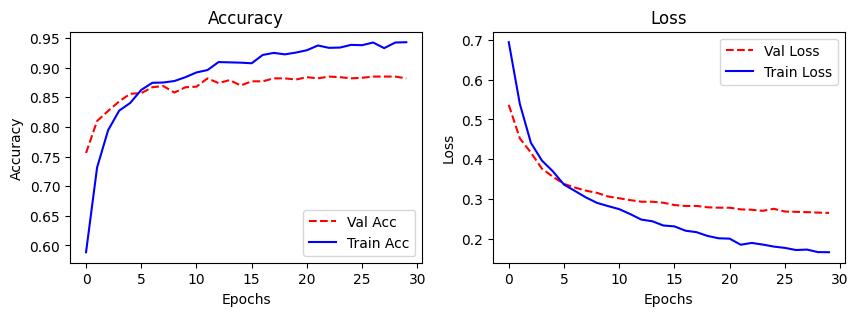

In [26]:
plots_with_val(history)